In [1]:
import uuid, sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast
import math
import random

from sklearn import metrics
from scipy import stats
from collections import Counter

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 2 on the node
print(torch.cuda.get_device_name(0))

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
import pytorch_lightning as pl
from torch.optim import AdamW

torch.manual_seed(0)

from accelerate import Accelerator
torch.cuda.empty_cache()
import training_utils.partitioning_utils as pat_utils
from tqdm import trange

Tesla V100-SXM2-32GB


In [105]:
import requests
requests.get("https://api.wandb.ai/status").status_code

import wandb
wandb.login(key="f8a6d759fe657b095d56bddbdb4d586dfaebd468", relogin=True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /zhome/c9/0/203261/.netrc


True

In [106]:
### Setting a seed to have the same initiation of weights

def set_seed(seed: int = 42):
    # Python & NumPy
    random.seed(seed)
    np.random.seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU

    # CuDNN settings (for convolution etc.)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # (Optional) for some Python hashing randomness
    os.environ["PYTHONHASHSEED"] = str(seed)

SEED = 0
set_seed(SEED)

In [107]:
os.chdir("/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts")
# print(os.getcwd())

print("PyTorch:", torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

PyTorch: 2.1.0+cu118
Using device: cuda
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts


In [108]:
# Model parameters
memory_verbose = False
use_wandb = True # Used to track loss in real-time without printing
model_save_steps = 1
train_frac = 1.0
test_frac = 1.0

embedding_dimension = 1152 #| 960 | 1152
number_of_recycles = 2
padding_value = -5000

In [109]:
# ## Training variables
runID = uuid.uuid4()

## Output path
trained_model_dir = f"/work3/s232958/data/trained/PPint_retrain10%_0.4_Christian/251116_{runID}"

def print_mem_consumption():
    # 1. Total memory available on the GPU (device 0)
    t = torch.cuda.get_device_properties(0).total_memory
    # 2. How much memory PyTorch has *reserved* from CUDA
    r = torch.cuda.memory_reserved(0)
    # 3. How much of that reserved memory is actually *used* by tensors
    a = torch.cuda.memory_allocated(0)
    # 4. Reserved but not currently allocated (so “free inside PyTorch’s pool”)
    f = r - a

    print("Total memory: ", t/1e9)      # total VRAM in GB
    print("Reserved memory: ", r/1e9)   # PyTorch’s reserved pool in GB
    print("Allocated memory: ", a//1e9) # actually in use (integer division)
    print("Free memory: ", f/1e9)       # slack in the reserved pool in GB
print_mem_consumption()

Total memory:  34.072559616
Reserved memory:  0.815792128
Allocated memory:  0.0
Free memory:  0.072034304


### Loading PPint dataframe

In [110]:
path_to_mmseqs_clustering = "/work3/s232958/data/PPint_DB/3_å_dataset5_singlefasta/clusterRes40"
all_seqs, clust, clust_keys = pat_utils.mmseqs_parser(path_to_mmseqs_clustering)

path_to_interaction_df = "/work3/s232958/data/PPint_DB/disordered_interfaces_no_cutoff_filtered_nonredundant80_3å_5.csv.gz"
disordered_interfaces_df = pd.read_csv(path_to_interaction_df,index_col=0).reset_index(drop=True)
disordered_interfaces_df["PDB_chain_name"] = (disordered_interfaces_df["PDB"] + "_" + disordered_interfaces_df["chainname"]).tolist()
disordered_interfaces_df["index_num"] = np.arange(len(disordered_interfaces_df))
disordered_interfaces_df["chain_name_index"] = [row["PDB_chain_name"] + "_" + str(row["index_num"]) for index, row in disordered_interfaces_df.iterrows()]
disordered_interfaces_df = disordered_interfaces_df.set_index("PDB_interface_name")
disordered_interfaces_df["interface_residues"] = disordered_interfaces_df["interface_residues"].apply(lambda x: ast.literal_eval(x))
# disordered_interfaces_df["inter_chain_hamming"] = [1 - (Ldistance(seq.split("-")[0], seq.split("-")[1]))/np.max([len(seq.split("-")[0]), len(seq.split("-")[1])]) for seq in disordered_interfaces_df["protien_interface_sequences"]]
disordered_interfaces_df["dimer"] = disordered_interfaces_df["inter_chain_hamming"] > 0.60
disordered_interfaces_df["clust_keys"] = [clust_keys.get(row["chain_name_index"]) for index, row in disordered_interfaces_df.iterrows()] 

pdb_interface_and_clust_keys = {index:disordered_interfaces_df.loc[index,"clust_keys"].values.tolist() for index in tqdm(disordered_interfaces_df.index.drop_duplicates(), total=len(disordered_interfaces_df)/2)}
new_clusters, new_clusters_clustkeys = pat_utils.recluster_mmseqs_keys_to_non_overlapping_groups(pdb_interface_and_clust_keys)

### Creating train and test datasets based on train and test-idexes
train_indexes, test_indexes = pat_utils.run_train_test_partition(interaction_df=disordered_interfaces_df,
                                                    clustering=new_clusters, # Clusters from Bidentate-graphs
                                                    train_ratio=0.8, 
                                                    test_ratio=0.2, 
                                                    v=True, 
                                                    seed=0)

disordered_interfaces_df["ID"] = [row["PDB"]+"_"+str(row["interface_index"])+"_"+row["chainname"] for __, row in disordered_interfaces_df.iterrows()]
disordered_interfaces_df["PDB_interface_name"] = disordered_interfaces_df.index

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 24725/24725.0 [00:33<00:00, 741.04it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 27834/27834 [00:00<00:00, 633034.69it/s]


0.8
0.2


In [111]:
print(f"Train indeces number: {len(train_indexes)}")
print(f"Test indeces number: {len(test_indexes)}")

Train indeces number: 19781
Test indeces number: 4944


In [112]:
# Creating new dataframe with pairs of proteins (PPints)
grouped = {}
for _, row in disordered_interfaces_df.iterrows():
    iface = row["PDB_interface_name"]
    seq = row["sequence"]
    rid = row["ID"]
    dimer = row["dimer"]
    
    if iface not in grouped:
        grouped[iface] = {
            "sequences": [],
            "IDs": [],
            "dimer": dimer,        # keep the dimer value for this interface
        }
    else:
        # Optional: sanity-check it's consistent per interface
        if grouped[iface]["dimer"] != dimer:
            print(f"Warning: multiple dimers for interface {iface}:",
                  grouped[iface]['dimer'], "vs", dimer)

    grouped[iface]["sequences"].append(seq)
    grouped[iface]["IDs"].append(rid)

records = []
for iface, vals in grouped.items():
    seqs = vals["sequences"]
    ids = vals["IDs"]
    if len(seqs) >= 2 and len(ids) >= 2:
        records.append({
            "interface_id": iface,
            "seq1": seqs[0],
            "seq2": seqs[1],
            "ID1": ids[0],
            "ID2": ids[1],
            "dimer": vals["dimer"],   # <- add dimer to final record
        })

PPint_interactions_NEW = pd.DataFrame(records)
PPint_interactions_NEW["seq_target_len"] = [len(row.seq1) for __, row in PPint_interactions_NEW.iterrows()]
PPint_interactions_NEW["seq_binder_len"] = [len(row.seq2) for __, row in PPint_interactions_NEW.iterrows()]
PPint_interactions_NEW["target_binder_id"] = PPint_interactions_NEW["ID1"] + "_" + PPint_interactions_NEW["ID2"]

PPint_interactions_NEW.head()

,interface_id,seq1,seq2,ID1,ID2,dimer,seq_target_len,seq_binder_len,target_binder_id
0,6NZA_0,MNTVRSEKDSMGAIDVPADKLWGAQTQRSLEHFRISTEKMPTSLIH...,TVRSEKDSMGAIDVPADKLWGAQTQRSLEHFRISTEKMPTSLIHAL...,6NZA_0_A,6NZA_0_B,True,461,459,6NZA_0_A_6NZA_0_B
1,9JKA_1,VAAGATLALLSFLTPLAFLLLPPLLWREELEPCGTACEGLFISVAF...,VAAGATLALLSFLTPLAFLLLPPLLWREELEPCGTACEGLFISVAF...,9JKA_1_B,9JKA_1_C,True,362,362,9JKA_1_B_9JKA_1_C
2,8DQ6_1,PTLNLFTNIPVDAVTCSDILKDATKAVAKIIGKPESYVMILLNSGV...,PTLNLFTNIPVDAVTCSDILKDATKAVAKIIGKPESYVMILLNSGV...,8DQ6_1_B,8DQ6_1_C,True,109,97,8DQ6_1_B_8DQ6_1_C
3,2YMZ_0,ARMFEMFNLDWKSGGTMKIKGHISEDAESFAINLGCKSSDLALHFN...,ARMFEMFNLDWKSGGTMKIKGHISEDAESFAINLGCKSSDLALHFN...,2YMZ_0_A,2YMZ_0_B,True,130,130,2YMZ_0_A_2YMZ_0_B
4,6IDB_0,DKICLGHHAVSNGTKVNTLTERGVEVVNATETVERTNIPRICSKGK...,GLFGAIAGFIENGWEGLIDGWYGFRHQNAQGEGTAADYKSTQSAID...,6IDB_0_A,6IDB_0_B,False,317,172,6IDB_0_A_6IDB_0_B


In [113]:
# sample random 10%
train_indexes_sample = random.sample(train_indexes, int(len(train_indexes) * 0.1))
test_indexes_sample = random.sample(test_indexes, int(len(test_indexes) * 0.1))

In [114]:
Df_test = PPint_interactions_NEW[PPint_interactions_NEW.interface_id.isin(test_indexes_sample)]
Df_test

,interface_id,seq1,seq2,ID1,ID2,dimer,seq_target_len,seq_binder_len,target_binder_id
7,4POB_0,DHATVTVTDDSFQEDVVSSNKPVLVDFWATWCGPCKMVAPVLEEIA...,ATVTVTDDSFQEDVVSSNKPVLVDFWATWCGPCKMVAPVLEEIAKD...,4POB_0_A,4POB_0_B,True,107,105,4POB_0_A_4POB_0_B
12,7T6C_0,YYPFVRKALFQLDPERAHEFTFQQLRRITGTPFEALVRQKVPAKPV...,YYPFVRKALFQLDPERAHEFTFQQLRRITGTPFEALVRQKVPAKPV...,7T6C_0_A,7T6C_0_B,True,335,335,7T6C_0_A_7T6C_0_B
28,1EGP_0,LKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTL,YNRVRVFYNPGTNVVNHVPHVG,1EGP_0_A,1EGP_0_B,False,39,22,1EGP_0_A_1EGP_0_B
62,7YH3_0,KVENPLLISLYSHYVEQILSETNSIDDANQKLRDLGKELGQQIYLN...,KVENPLLISLYSHYVEQILSETNSIDDANQKLRDLGKELGQQIYLN...,7YH3_0_A,7YH3_0_C,True,150,155,7YH3_0_A_7YH3_0_C
70,4WMO_1,GYRSCNEIKSSDSRAPDGIYTLATEDGESYQTFCDTTNGGGWTLVA...,GYRSCNEIKSSDSRAPDGIYTLATEDGESYQTFCDTTNGGGWTLVA...,4WMO_1_D,4WMO_1_E,True,271,271,4WMO_1_D_4WMO_1_E
...,...,...,...,...,...,...,...,...,...
24455,2OYS_0,NKIFIYAGVRNHNSKTLEYTKRLSSIISSRNNVDISFRTPFNSELE...,NKIFIYAGVRNHNSKTLEYTKRLSSIISSRNNVDISFRTPFNSELE...,2OYS_0_A,2OYS_0_B,True,227,227,2OYS_0_A_2OYS_0_B
24491,6XRF_1,TLYRLHEADLEIPDAWQDQSINIFKLPASGPAREASFVISRDASQG...,MDAQAAARLGDEIAHGFGVAAMVAGAVAGALIGAAVVAAATGGLAA...,6XRF_1_B,6XRF_1_C,False,140,57,6XRF_1_B_6XRF_1_C
24507,5Z2L_0,GAFTGKTVLILGGSRGIGAAIVRRFVTDGANVRFTYAGSKDAAKRL...,GAFTGKTVLILGGSRGIGAAIVRRFVTDGANVRFTYAGSKDAAKRL...,5Z2L_0_A,5Z2L_0_B,True,239,243,5Z2L_0_A_5Z2L_0_B
24617,4LRS_0,APRVRITDSTLRDGSHAMAHQFTEEQVRATVHALDAAGVEVIEVSH...,GKAVAAIVGPGNIGTDLLIKLQRSEHIEVRYMVGVDPASEGLARAR...,4LRS_0_A,4LRS_0_B,False,337,294,4LRS_0_A_4LRS_0_B


## Model without the structure evaluation

### Loading Data

In [147]:
class CLIP_PPint_analysis_dataset(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim=1152,
        embedding_pad_value=-5000.0,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = int(embedding_dim)
        self.emb_pad = float(embedding_pad_value)

        # lengths
        self.max_blen = self.dframe["seq_binder_len"].max()
        self.max_tlen = self.dframe["seq_target_len"].max()

        # paths
        self.encoding_bpath, self.encoding_tpath = paths

        # index & storage
        self.dframe.set_index("target_binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESMC embeddings"):
            parts = accession.split("_") # e.g. accession 7S8T_5_F_7S8T_5_G
            tgt_id = "_".join(parts[:3])
            bnd_id = "_".join(parts[3:])

            ### --- embeddings (pad to fixed lengths) --- ###
            
            # laod embeddings
            t_emb = np.load(os.path.join(self.encoding_tpath, f"{tgt_id}.npy"))[0]     # [Lt, D]
            b_emb = np.load(os.path.join(self.encoding_bpath, f"{bnd_id}.npy"))[0]     # [Lb, D]

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            self.samples.append((b_emb, t_emb))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_arr, t_arr = self.samples[idx]
        binder_emb, target_emb = torch.from_numpy(b_arr).float(), torch.from_numpy(t_arr).float()
        label = torch.tensor(1, dtype=torch.float32)  # single scalar labe
        return binder_emb, target_emb, label

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
    
        # Stack labels
        labels = torch.stack(lbl_list)  # [B]
    
        return b, t, labels

bemb_path = "/work3/s232958/data/PPint_DB/embeddings_esmC"
temb_path = "/work3/s232958/data/PPint_DB/embeddings_esmC"

testing_Dataset = CLIP_PPint_analysis_dataset(
    Df_test,
    paths=[bemb_path, temb_path],
    embedding_dim=1152
)

Df_test_non_dimer = Df_test[Df_test.dimer == False]

non_dimers_Dataset = CLIP_PPint_analysis_dataset(
    Df_test_non_dimer,
    paths=[bemb_path, temb_path],
    embedding_dim=1152
)

#Loading ESMC embeddings: 100%|██████████████████████████████████████████████████████████████████████████████████| 130/130 [00:00<00:00, 149.49it/s]


In [116]:
class CLIP_PPint_MetaData(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim=1152,
        embedding_pad_value=-5000.0
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = int(embedding_dim)
        self.emb_pad = float(embedding_pad_value)
        self.max_blen = self.dframe["seq_binder_len"].max()
        self.max_tlen = self.dframe["seq_target_len"].max()

        # paths
        self.encoding_bpath, self.encoding_tpath = paths

        # index & storage
        self.dframe.set_index("binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings"):
            lbl = torch.tensor(int(self.dframe.loc[accession, "binder_label"]))
            parts = accession.split("_") # e.g. accession 7S8T_5_F_7S8T_5_G
            tgt_id = "_".join(parts[:-1])
            bnd_id = accession

            ### --- embeddings (pad to fixed lengths) --- ###
            
            # laod embeddings
            t_emb = np.load(os.path.join(self.encoding_tpath, f"{tgt_id}.npy"))[0]     # [Lt, D]
            b_emb = np.load(os.path.join(self.encoding_bpath, f"{bnd_id}.npy"))[0]     # [Lb, D]

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            self.samples.append((b_emb, t_emb, lbl))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_arr, t_arr, lbls = self.samples[idx]
        binder_emb, target_emb = torch.from_numpy(b_arr).float(), torch.from_numpy(t_arr).float()
        return binder_emb, target_emb, lbls

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
    
        # Stack labels
        labels = torch.stack(lbl_list)  # [B]
    
        return b, t, labels

bemb_path = "/work3/s232958/data/meta_analysis/binders_embeddings_esmC"
temb_path = "/work3/s232958/data/meta_analysis/targets_embeddings_esmC"

validation_Dataset = CLIP_PPint_MetaData(
    # interaction_df_shuffled[:len(Df_test)],
    interaction_df_shuffled,
    paths=[bemb_path, temb_path],
    embedding_dim=1152
)

#Loading ESM2 embeddings: 100%|████████████████████████████████████████████████████████████████████████████████| 3532/3532 [00:26<00:00, 134.45it/s]


In [117]:
accessions_Meta = list(interaction_df_shuffled.binder_id)
emb_b, emb_t, labels = validation_Dataset._get_by_name(accessions_Meta[:5])
labels

tensor([1, 0, 0, 0, 0])

### Loading Pre-trained Model

In [126]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=embedding_dimension, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value
        self.embed_dimension = embed_dimension

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init

        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)  # For residual additions

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
        
    def forward(self, pep_input, prot_input, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input, padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input, padding_value=self.padding_value)
 
        # Initialize residual states
        pep_emb = pep_input.clone()
        prot_emb = prot_input.clone()
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            pep_emb = pep_emb + pep_trans  
            prot_emb = prot_emb + prot_trans

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # Use self-attention outputs for embeddings
        pep_seq_coding = F.normalize(self.prot_embedder(pep_seq_coding), dim=-1)
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding), dim=-1)
 
        if mem_save:
            torch.cuda.empty_cache()
        
        scale = torch.exp(self.logit_scale).clamp(max=100.0)
        logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1)
        
        return logits

    def training_step(self, batch, device):
        embedding_pep, embedding_prot, labels = batch
        embedding_pep, embedding_prot = embedding_pep.to(device), embedding_prot.to(device)
        
        positive_logits = self.forward(embedding_pep, embedding_prot)
        
        # Negative indexes
        rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1)         
        
        negative_logits = self(embedding_pep[rows,:,:], 
                          embedding_prot[cols,:,:], 
                          int_prob=0.0)

        # loss of predicting partner using peptide
        positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
 
        # loss of predicting peptide using partner
        negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))
        
        loss = (positive_loss + negative_loss) / 2
 
        # del partner_prediction_loss, peptide_prediction_loss, embedding_pep, embedding_prot
        torch.cuda.empty_cache()
        return loss

    def validation_step_PPint(self, batch, device):
        # Predict on random batches of training batch size
        embedding_pep, embedding_prot, labels = batch
        embedding_pep, embedding_prot = embedding_pep.to(device), embedding_prot.to(device)
        
        with torch.no_grad():

            positive_logits = self(embedding_pep, embedding_prot)
            
            # loss of predicting partner using peptide
            positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
            
            # Negaive indexes
            rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1)
            
            negative_logits = self(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)
    
            negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))

            loss = (positive_loss + negative_loss) / 2
           
            logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
            logit_matrix[rows, cols] = negative_logits
            logit_matrix[cols, rows] = negative_logits
            
            # Fill diagonal with positive scores
            diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
            logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()

            labels = torch.arange(embedding_prot.size(0)).to(self.device)
            peptide_predictions = logit_matrix.argmax(dim=0)
            peptide_ranks = logit_matrix.argsort(dim=0).diag() + 1
            peptide_mrr = (peptide_ranks).float().pow(-1).mean()
            
            # partner_accuracy = partner_predictions.eq(labels).float().mean()
            peptide_accuracy = peptide_predictions.eq(labels).float().mean()
    
            k = 3
            peptide_topk_accuracy = torch.any((logit_matrix.topk(k, dim=0).indices - labels.reshape(1, -1)) == 0, dim=0).sum() / logit_matrix.shape[0]
    
            del logit_matrix,positive_logits,negative_logits,embedding_pep,embedding_prot

            return loss, peptide_accuracy, peptide_topk_accuracy
    
    def validation_step_MetaDataset(self, batch, device):
        embedding_binder, embedding_target, labels = batch
        embedding_binder = embedding_binder.to(device)
        embedding_target = embedding_target.to(device)
        labels = labels.to(device).float()
    
        with torch.no_grad():
            logits = self.forward(embedding_binder, embedding_target)
            logits = logits.float()
            loss = F.binary_cross_entropy_with_logits(logits.view(-1), labels.view(-1))
            return logits, loss

    def calculate_logit_matrix(self,embedding_pep,embedding_prot):
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        
        positive_logits = self(embedding_pep, embedding_prot)
        negative_logits = self(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)
        
        logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        
        diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        
        return logit_matrix

In [127]:
model = MiniCLIP_w_transformer_crossattn(embed_dimension=1152, num_recycles=2).to("cuda")
path = "/work3/s232958/data/trained/PPint_retrain10%_0.4_Christian/251116_0e035ba9-3cbd-4aab-be0b-cc2e37723b27/0e035ba9-3cbd-4aab-be0b-cc2e37723b27_checkpoint_8/0e035ba9-3cbd-4aab-be0b-cc2e37723b27_checkpoint_epoch_8.pth"
checkpoint = torch.load(path, weights_only=False, map_location=torch.device('cpu'))
# print(list(checkpoint["model_state_dict"]))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()  

MiniCLIP_w_transformer_crossattn(
  (transformerencoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
    )
    (linear1): Linear(in_features=1152, out_features=1152, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1152, out_features=1152, bias=True)
    (norm1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
  )
  (prot_embedder): Sequential(
    (0): Linear(in_features=1152, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=32

In [149]:
def collate_varlen(batch):
    b_emb = torch.stack([x[0] for x in batch], dim=0)
    t_emb = torch.stack([x[1] for x in batch], dim=0)
    lbls = torch.tensor([x[2].float() for x in batch])
    return b_emb, t_emb, lbls

test_dataloader = DataLoader(testing_Dataset, batch_size=10, collate_fn=collate_varlen)
non_dimers_dataloader = DataLoader(non_dimers_Dataset, batch_size=10, collate_fn=collate_varlen)

In [150]:
interaction_scores_pos = []
interaction_scores_neg = []    

for batch in tqdm(test_dataloader, total=round(len(Df_test)/10), desc="#Iterating through batched data"):
    b_emb, t_emb, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():

        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        positive_logits = model(embedding_pep, embedding_prot)
        negative_logits = model(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)
        
        logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device="cuda")
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        
        diag_indices = torch.arange(embedding_pep.size(0), device="cuda")
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        
        # print(logit_matrix)
        interaction_scores_pos.append(positive_logits)
        interaction_scores_neg.append(negative_logits)

# Convert list of tensors to single 1D tensors
pos_logits = torch.cat(interaction_scores_pos).detach().cpu().numpy()
neg_logits = torch.cat(interaction_scores_neg).detach().cpu().numpy()
print("Positives:", pos_logits.shape)
print("Negatives:", neg_logits.shape)

#Iterating through batched data: 50it [00:17,  2.87it/s]                                                                                            

Positives: (494,)
Negatives: (2211,)


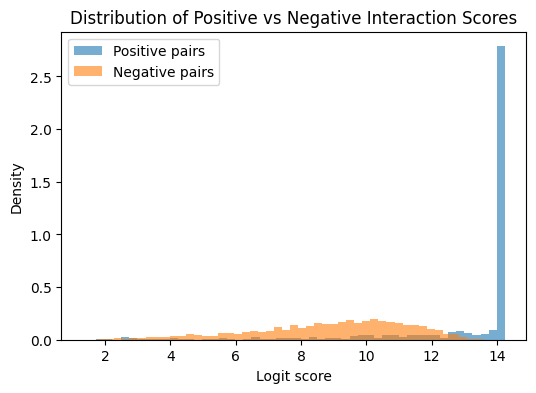

In [151]:
plt.figure(figsize=(6, 4))
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)
plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")
plt.legend()
plt.show()

#### non-dimers

In [156]:
interaction_scores = []

for batch in tqdm(non_dimers_dataloader, total=round(len(Df_test_non_dimer)/10), desc="#Iterating through batched data"):
    b_emb, t_emb, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():
        positive_logits = model(embedding_pep, embedding_prot)
        interaction_scores.append(positive_logits.unsqueeze(0))

# Convert list of tensors to single 1D tensors
predicted_interaction_scores = np.concatenate([batch_score.cpu().detach().numpy().reshape(-1,) for batch_score in interaction_scores])
# interaction_probabilities = np.concatenate([torch.sigmoid(batch_score[0]).cpu().numpy() for batch_score in interaction_scores])

#Iterating through batched data: 100%|██████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 13.28it/s]


## With Structure

In [159]:
class CLIP_PPint_analysis_dataset(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim=1280,
        embedding_pad_value=-5000.0,
        structure_pad_value=0.0,
        p=16
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = embedding_dim
        self.emb_pad = embedding_pad_value
        self.struct_pad = structure_pad_value
        self.p = p

        # lengths
        self.max_blen = self.dframe["seq_binder_len"].max()
        self.max_tlen = self.dframe["seq_target_len"].max()

        # patch extractor
        # patchify --> flatten each patch to p*p dim=1 --> stack pacthes
        # self.unfold = nn.Unfold(kernel_size=self.p, stride=self.p)
        self.unfold = nn.Unfold(kernel_size=self.p, stride=p)

        # paths
        self.encoding_bpath, self.encoding_tpath, self.contacts_bpath, self.contacts_tpath = paths

        # index & storage
        self.dframe.set_index("target_binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):
            parts = accession.split("_") # e.g. accession 7S8T_5_F_7S8T_5_G
            tgt_id = "_".join(parts[:3])
            bnd_id = "_".join(parts[3:])

            ### --- embeddings (pad to fixed lengths) --- ###
            
            # laod embeddings
            t_emb = np.load(os.path.join(self.encoding_tpath, f"{tgt_id}.npy"))     # [Lt, D]
            b_emb = np.load(os.path.join(self.encoding_bpath, f"{bnd_id}.npy"))     # [Lb, D]

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            ### --- contacts → tokens (zero pad for patching, unfold, add sinusoid PE, pad to global patch indeces length) --- ###
            
            t_cont = np.load(os.path.join(self.contacts_tpath, f"{tgt_id}.npy"))    # [Lt, Lt]
            b_cont = np.load(os.path.join(self.contacts_bpath, f"{bnd_id}.npy"))    # [Lb, Lb]

            t_tok = self._contact_to_tokens(t_cont)                  # [L_s_t, p*p]
            b_tok = self._contact_to_tokens(b_cont)                  # [L_s_b, p*p]

            self.samples.append((b_emb, t_emb, b_tok, t_tok))

    def _contact_to_tokens(self, cont_np: np.ndarray) -> torch.Tensor:
        """
        Purpose: return flattened stacked patches
        """        
        # to NCHW
        x = torch.from_numpy(cont_np).float()[None, None, ...]   # [1,1,N,N]

        # zero-pad right and bototm to be divisible by p
        N = cont_np.shape[0]
        Hs = ((N + self.p - 1) // self.p) * self.p
        pad = Hs - N
        x = F.pad(x, (0, pad, 0, pad), value=0.0) # [1,1,Hs,Hs]

        # unfold to non-overlapping p×p
        # squeeze [1, p*p, Ls] --> transpose [p*p, Ls] --> [Ls, p*p]
        cols = self.unfold(x).squeeze(0).transpose(0, 1).contiguous()  
        return cols

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_arr, t_arr, b_tok, t_tok = self.samples[idx]
        binder_emb, target_emb = torch.from_numpy(b_arr).float(), torch.from_numpy(t_arr).float()
        binder_ct, target_ct = b_tok.float(), t_tok.float()
        label = torch.tensor(1, dtype=torch.float32)  # single scalar labe
        return binder_emb, target_emb, binder_ct, target_ct, label

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, bct_list, tct_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
    
        # Keep contacts as lists
        bct = [torch.as_tensor(x) for x in bct_list]
        tct = [torch.as_tensor(x) for x in tct_list]
    
        # Stack labels
        labels = torch.stack(lbl_list)  # [B]
    
        return b, t, bct, tct, labels

In [160]:
bemb_path = "/work3/s232958/data/PPint_DB/binders_embeddings_esm2"
temb_path = "/work3/s232958/data/PPint_DB/targets_embeddings_esm2"

## Contact maps paths
bcont_path = "/work3/s232958/data/PPint_DB/binders_contacts"
tcont_path = "/work3/s232958/data/PPint_DB/targets_contacts"

testing_Dataset = CLIP_PPint_analysis_dataset(
    Df_test,
    paths=[bemb_path, temb_path, bcont_path, tcont_path],
    embedding_dim=1280
)

#Loading ESM2 embeddings and contacts: 100%|██████████████████████████████████████████████████████████████████████| 494/494 [00:06<00:00, 75.03it/s]


In [161]:
class CLIP_Meta_analysis_dataset(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim=1280,
        embedding_pad_value=-5000.0,
        structure_pad_value=0.0,
        p=16,
        fixed_max_blen=None,
        fixed_max_tlen=None,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = int(embedding_dim)
        self.emb_pad = float(embedding_pad_value)
        self.struct_pad = float(structure_pad_value)
        self.p = int(p)

        # lengths
        self.max_blen = self.dframe["seq_binder_len"].max()
        self.max_tlen = self.dframe["seq_target_len"].max()

        # patch extractor
        # patchify --> flatten each patch to p*p dim=1 --> stack pacthes
        self.unfold = nn.Unfold(kernel_size=self.p, stride=self.p)

        # paths
        self.encoding_bpath, self.encoding_tpath, self.contacts_bpath, self.contacts_tpath = paths

        # index & storage
        self.dframe.set_index("binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):
            lbl = torch.tensor(int(self.dframe.loc[accession, "binder_label"]))
            parts = accession.split("_") # e.g. accession 7S8T_5_F_7S8T_5_G
            tgt_id = "_".join(parts[:-1])
            bnd_id = accession

            ### --- embeddings (pad to fixed lengths) --- ###
            
            # laod embeddings
            t_emb = np.load(os.path.join(self.encoding_tpath, f"{tgt_id}.npy"))     # [Lt, D]
            b_emb = np.load(os.path.join(self.encoding_bpath, f"{bnd_id}.npy"))     # [Lb, D]

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            ### --- contacts → tokens (zero pad for patching, unfold, add sinusoid PE, pad to global patch indeces length) --- ###
            
            t_cont = np.load(os.path.join(self.contacts_tpath, f"{tgt_id}.npy"))    # [Lt, Lt]
            b_cont = np.load(os.path.join(self.contacts_bpath, f"{bnd_id}.npy"))    # [Lb, Lb]

            t_tok = self._contact_to_tokens(t_cont)                  # [L_s_t, p*p]
            b_tok = self._contact_to_tokens(b_cont)                  # [L_s_b, p*p]

            self.samples.append((b_emb, t_emb, b_tok, t_tok, lbl))

    def _contact_to_tokens(self, cont_np: np.ndarray) -> torch.Tensor:
        """
        Purpose: return flattened stacked patches
        """        
        # to NCHW
        x = torch.from_numpy(cont_np).float()[None, None, ...]   # [1,1,N,N]

        # zero-pad right and bototm to be divisible by p
        N = cont_np.shape[0]
        Hs = ((N + self.p - 1) // self.p) * self.p
        pad = Hs - N
        x = F.pad(x, (0, pad, 0, pad), value=0.0) # [1,1,Hs,Hs]

        # unfold to non-overlapping p×p
        # squeeze [1, p*p, Ls] --> transpose [p*p, Ls] --> [Ls, p*p]
        cols = self.unfold(x).squeeze(0).transpose(0, 1).contiguous()  
        return cols
        
    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_arr, t_arr, b_tok, t_tok, lbls = self.samples[idx]
        binder_emb, target_emb = torch.from_numpy(b_arr).float(), torch.from_numpy(t_arr).float()
        binder_ct, target_ct = b_tok.float(), t_tok.float()
        return binder_emb, target_emb, binder_ct, target_ct, lbls

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, bct_list, tct_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
    
        # Keep contacts as lists
        bct = [torch.as_tensor(x) for x in bct_list]
        tct = [torch.as_tensor(x) for x in tct_list]
    
        # Stack labels
        labels = torch.stack(lbl_list)  # [B]
    
        return b, t, bct, tct, labels

bemb_path = "/work3/s232958/data/meta_analysis/binders_embeddings_esm2"
temb_path = "/work3/s232958/data/meta_analysis/targets_embeddings_esm2"

## Contact maps paths
bcont_path = "/work3/s232958/data/meta_analysis/binders_contacts"
tcont_path = "/work3/s232958/data/meta_analysis/targets_contacts"

validation_Dataset = CLIP_Meta_analysis_dataset(
    interaction_df_shuffled,
    paths=[bemb_path, temb_path, bcont_path, tcont_path],
    embedding_dim=1280
)

#Loading ESM2 embeddings and contacts: 100%|████████████████████████████████████████████████████████████████████| 3532/3532 [00:35<00:00, 98.51it/s]


### Loading Model

In [162]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    """
    Purpose: return vector indicating which rows are not padded (don't have values = -5000)
    """
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1280] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

def get_sinusoid_encoding(num_tokens, token_len):
    """
    Purpose: positional encoding having the same dimensions as token matrix
    Standard Vaswani sinusoidal positional encoding for a sequence of length L=num_tokens and dim D=token_len.
    Returns: [L, D] tensor (no batch dim).
    """
    device = torch.device("cpu")
    L, D = num_tokens, token_len
    pos = torch.arange(L, dtype=torch.float32, device=device).unsqueeze(1)      # [L,1]
    i   = torch.arange(D, dtype=torch.float32, device=device).unsqueeze(0)      # [1,D]
    div = torch.pow(10000.0, (2 * torch.floor(i/2)) / D)                        # [1,D]
    angles = pos / div                                                          # [L,D]
    pe = torch.zeros(L, D, dtype=torch.float32, device=device)
    pe[:, 0::2] = torch.sin(angles[:, 0::2])
    pe[:, 1::2] = torch.cos(angles[:, 1::2])
    return pe

def pad_tokens_to_L(tokens: torch.Tensor, L_target: int):
    if tokens.dim() == 3:
        B, Ls, D = tokens.shape
        if Ls >= L_target:
            return tokens[:, :L_target, :]
        pad = tokens.new_zeros(B, L_target - Ls, D)
        return torch.cat([tokens, pad], dim=1)
    elif tokens.dim() == 2:
        Ls, D = tokens.shape
        if Ls >= L_target:
            return tokens[:L_target]
        pad = tokens.new_zeros(L_target - Ls, D)
        return torch.cat([tokens, pad], dim=0)
    else:
        raise ValueError(f"Unexpected tokens.dim()={tokens.dim()} (wanted 2 or 3)")

In [163]:
class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(
        self,
        padding_value=-5000,
        seq_embed_dimension = 1280,
        struct_embed_dimension = 256,
        num_recycles=2
    ):
        super().__init__()
        self.num_recycles = num_recycles # 2
        self.padding_value = padding_value # -5000
        self.seq_embed_dimension = seq_embed_dimension # 1280
        self.struct_embed_dimension = struct_embed_dimension # 256

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init
        self.struct_alpha = nn.Parameter(torch.tensor(0.0))
        self.pe_scale = nn.Parameter(torch.tensor(0.1))

        ### SEQUENCE ###
        # self attention
        self.seq_encoder = nn.TransformerEncoderLayer(
            d_model=self.seq_embed_dimension, 
            nhead=8,
            dropout=0.1, 
            batch_first=True, 
            dim_feedforward=self.seq_embed_dimension)

        self.norm_seq = nn.LayerNorm(self.seq_embed_dimension)  # For residual additions

        # cross attention
        self.seq_cross_attn = nn.MultiheadAttention(
            embed_dim=self.seq_embed_dimension, 
            num_heads=8,
            dropout=0.1, 
            batch_first=True)

        self.projection_head= nn.Sequential(
            nn.Linear(self.seq_embed_dimension, 640), 
            nn.ReLU(), 
            nn.Linear(640, 320))

        ### STRUCTURE ###
        
        # Linear projection of flat patches
        self.token_project = nn.Linear(
            self.struct_embed_dimension,
            self.seq_embed_dimension, 
            bias=True)

        self.norm_struct = nn.LayerNorm(self.seq_embed_dimension)  # For residual additions
        
        # self attention        
        self.struct_encoder = nn.TransformerEncoderLayer(
            d_model=self.seq_embed_dimension, 
            nhead=8,
            dropout=0.1, 
            batch_first=True, 
            dim_feedforward=self.seq_embed_dimension)

        self.struct_to_seq_attn = nn.MultiheadAttention(
            embed_dim=self.seq_embed_dimension, 
            num_heads=8,
            dropout=0.1, 
            batch_first=True)
                
    def forward(self, pep_emb, prot_emb, pep_contacts_list, prot_contacts_list, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True):

        pep_max_len, prot_max_len = max(x.size(0) for x in pep_contacts_list), max(x.size(0) for x in prot_contacts_list)
        
        ### nn.Linear() --> + PE -->padding to max token index 
        # 1. Linear projection of flat contacts
        pep_cm_proj  = [self.token_project(x.to(device)) for x in pep_contacts_list]
        prot_cm_proj  = [self.token_project(x.to(device)) for x in prot_contacts_list]
        del pep_contacts_list, prot_contacts_list
                
        # 2. + positional encoding (unchanged lists, but now scaled)
        pep_pe = [get_sinusoid_encoding(cm.shape[0], cm.shape[1]).to(device) for cm in pep_cm_proj]
        pep_cm_pos = [cm + self.pe_scale * pe for cm, pe in zip(pep_cm_proj, pep_pe)]
        
        prot_pe = [get_sinusoid_encoding(cm.shape[0], cm.shape[1]).to(device) for cm in prot_cm_proj]
        prot_cm_pos = [cm + self.pe_scale * pe for cm, pe in zip(prot_cm_proj, prot_pe)]

        # 3. Pad dim=0 for batch
        pep_cm_pos = torch.stack([pad_tokens_to_L(cm, pep_max_len) for cm in pep_cm_pos], dim=0)
        prot_cm_pos = torch.stack([pad_tokens_to_L(cm, prot_max_len) for cm in prot_cm_pos], dim=0)
        
        # Key padding masks (True = pad -> to be ignored by attention)
        pep_mask_emb = create_key_padding_mask(embeddings = pep_emb, padding_value = self.padding_value).to(device)   # [B, Lp]
        prot_mask_emb = create_key_padding_mask(embeddings = prot_emb, padding_value = self.padding_value).to(device)    # [B, Lt]
        
        pep_mask_cm = create_key_padding_mask(embeddings = pep_cm_pos, padding_value = self.padding_value).to(device)     # [B, Lp_cm]
        prot_mask_cm = create_key_padding_mask(embeddings = prot_cm_pos, padding_value = self.padding_value).to(device)     # [B, Lt_cm]
    
        # Residual states
        pep_emb = pep_emb.to(device)
        prot_emb = prot_emb.to(device)
        pep_contacts = pep_cm_pos.to(device)
        prot_contacts = prot_cm_pos.to(device)
        # pep_emb, prot_emb, pep_contacts, prot_contacts = pep_emb.clone(), prot_emb.clone(), pep_cm_pos.clone(), prot_cm_pos.clone()
    
        for _ in range(self.num_recycles):
            
            # --- Self-attention encoders (embedding streams) ---
            pep_trans_emb = self.seq_encoder(self.norm_seq(pep_emb), src_key_padding_mask=pep_mask_emb)   # [B, Lp, E]
            prot_trans_emb = self.seq_encoder(self.norm_seq(prot_emb), src_key_padding_mask=prot_mask_emb)  # [B, Lt, E]
    
            # --- Self-attention encoders (structure streams) ---
            pep_trans_cm = self.struct_encoder(self.norm_struct(pep_contacts), src_key_padding_mask=pep_mask_cm)   # [B, Lp_cm, E]
            prot_trans_cm = self.struct_encoder(self.norm_struct(prot_contacts), src_key_padding_mask=prot_mask_cm)  # [B, Lt_cm, E]

            # --- Cross-attend to structures ---
            pep_struct_upd, _ = self.struct_to_seq_attn(query=self.norm_seq(pep_trans_emb), key=self.norm_struct(pep_trans_cm), value=self.norm_struct(pep_trans_cm), key_padding_mask=pep_mask_cm)
            prot_struct_upd, _ = self.struct_to_seq_attn(query=self.norm_seq(prot_trans_emb), key=self.norm_struct(prot_trans_cm), value=self.norm_struct(prot_trans_cm), key_padding_mask=prot_mask_cm)

            pep_trans_emb  = pep_trans_emb  + self.struct_alpha.tanh() * pep_struct_upd    # [B, Lp, E]
            prot_trans_emb = prot_trans_emb + self.struct_alpha.tanh() * prot_struct_upd    # [B, Lt, E]
    
            # --- Cross-attend binder vs target ---
            pep_cross,  _  = self.seq_cross_attn(query=self.norm_seq(pep_trans_emb), key=self.norm_seq(prot_trans_emb), value=self.norm_seq(prot_trans_emb), key_padding_mask=prot_mask_emb)
            prot_cross, _  = self.seq_cross_attn(query=self.norm_seq(prot_trans_emb), key=self.norm_seq(pep_trans_emb), value=self.norm_seq(pep_trans_emb), key_padding_mask=pep_mask_emb)
    
            # --- Residual updates ---
            pep_emb = pep_emb + pep_cross
            prot_emb = prot_emb + prot_cross
    
        # Pool (mean over non-masked positions)
        pep_seq_coding   = create_mean_of_non_masked(pep_emb, pep_mask_emb)
        prot_seq_coding  = create_mean_of_non_masked(prot_emb, prot_mask_emb)

        # Projections + L2-normalize
        pep_full   = F.normalize(self.projection_head(pep_seq_coding),   dim=-1)
        prot_full  = F.normalize(self.projection_head(prot_seq_coding),  dim=-1)
    
        if mem_save:
            torch.cuda.empty_cache()
    
        scale  = torch.exp(self.logit_scale).clamp(max=100.0)
        logits = scale * (pep_full * prot_full).sum(dim=-1)  # [B]

        del pep_emb, prot_emb, pep_contacts, prot_contacts
        
        return logits

    def training_step(self, batch, device):
        embedding_pep, embedding_prot, contacts_pep, contacts_prot, labels = batch
        # embedding_pep, embedding_prot, contacts_pep, contacts_prot = embedding_pep.to(device), embedding_prot.to(device), contacts_binder.to(device), contacts_prot.to(device)

        # loss of predicting partner using peptide
        positive_logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
        positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device)) # F.binary_cross_entropy_with_logits does sigmoid transfromation inside, excepts data, labels
        
        # Negative indexes
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1) # upper triangle
        
        pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
        prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]

        # loss of predicting peptide using partner
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], contacts_pep[rows,:,:], contacts_prot[cols,:,:], int_prob=0.0)
        negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
        negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))
        
        loss = (positive_loss + negative_loss) / 2
 
        # del partner_prediction_loss, peptide_prediction_loss, embedding_pep, embedding_prot
        torch.cuda.empty_cache()
        return loss

    def validation_step_PPint(self, batch, device):
        # Predict on random batches of training batch size
        embedding_pep, embedding_prot, contacts_pep, contacts_prot, labels = batch
        embedding_pep, embedding_prot = embedding_pep.to(device), embedding_prot.to(device)
        # contacts_pep, contacts_prot = contacts_pep.to(device), contacts_prot.to(device)
        
        with torch.no_grad():

            positive_logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
            
            # loss of predicting partner using peptide
            positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
            
            # Negaive indexes
            rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1)
            
            pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
            prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]
            
            negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
            negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))

            loss = (positive_loss + negative_loss) / 2

            logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
            logit_matrix[rows, cols] = negative_logits
            logit_matrix[cols, rows] = negative_logits
            
            # Fill diagonal with positive scores
            diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
            logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()

            labels = torch.arange(embedding_prot.size(0)).to(self.device)
            peptide_predictions = logit_matrix.argmax(dim=0)
            peptide_ranks = logit_matrix.argsort(dim=0).diag() + 1
            peptide_mrr = (peptide_ranks).float().pow(-1).mean()
            
            # partner_accuracy = partner_predictions.eq(labels).float().mean()
            peptide_accuracy = peptide_predictions.eq(labels).float().mean()
    
            del logit_matrix,positive_logits,negative_logits,embedding_pep,embedding_prot

            return loss, peptide_accuracy
    
    def validation_step_MetaDataset(self, batch, device):
        embedding_pep, embedding_prot, contacts_pep, contacts_prot, labels = batch
        embedding_pep, embedding_prot = embedding_pep.to(device), embedding_prot.to(device)
        # contacts_pep, contacts_prot = contacts_pep.to(device), contacts_prot.to(device)
        labels = labels.to(device).float()
    
        with torch.no_grad():
            logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot).float()
            loss = F.binary_cross_entropy_with_logits(logits.view(-1), labels.view(-1))
            return logits, loss

    def calculate_logit_matrix(self, embedding_pep, embedding_prot, contacts_pep, contacts_prot):
        
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
        prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]
        
        positive_logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], contacts_pep[rows,:,:], contacts_prot[cols,:,:], int_prob=0.0)
        negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
        
        logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        
        diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        
        return logit_matrix

In [185]:
def collate_varlen(batch):
    b_emb = torch.stack([x[0] for x in batch], dim=0)  # fixed length -> stack
    t_emb = torch.stack([x[1] for x in batch], dim=0)
    b_ctok = [x[2] for x in batch]                     # var-len -> list
    t_ctok = [x[3] for x in batch]
    # lbls = torch.tensor([float(x[4]) for x in batch])
    lbls = torch.tensor([x[4].float() for x in batch])
    return b_emb, t_emb, b_ctok, t_ctok, lbls

testing_dataloader = DataLoader(testing_Dataset, batch_size=10, collate_fn=collate_varlen)
validation_dataloader = DataLoader(validation_Dataset, batch_size=10, shuffle=False, drop_last = False, collate_fn=collate_varlen)

In [165]:
path = '/work3/s232958/data/trained/PPint_retrain10%_0.4_Christian_w_structure/arch2/251116_5a5a437d-0403-4209-b8c4-09eaf5bda508/5a5a437d-0403-4209-b8c4-09eaf5bda508_checkpoint_8/5a5a437d-0403-4209-b8c4-09eaf5bda508_checkpoint_epoch_8.pth'
checkpoint = torch.load(path, weights_only=False, map_location=torch.device('cpu'))
# print(list(checkpoint["model_state_dict"]))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MiniCLIP_w_transformer_crossattn()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()  # or model.train()

MiniCLIP_w_transformer_crossattn(
  (seq_encoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
    )
    (linear1): Linear(in_features=1280, out_features=1280, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1280, out_features=1280, bias=True)
    (norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm_seq): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  (seq_cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
  )
  (projection_head): Sequential(
    (0): Linear(in_features=1280, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features

In [166]:
interaction_scores_pos = []
interaction_scores_neg = []    

for batch in tqdm(testing_dataloader, total=round(len(Df_test)/10), desc="#Iterating through batched data"):
    b_emb, t_emb, contacts_pep, contacts_prot, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():

        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
        prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]
        
        positive_logits = model(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
        negative_logits = model(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
        
        logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device="cuda")
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        
        diag_indices = torch.arange(embedding_pep.size(0), device="cuda")
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        
        # print(logit_matrix)
        interaction_scores_pos.append(positive_logits)
        interaction_scores_neg.append(negative_logits)

# Convert list of tensors to single 1D tensors
pos_logits = torch.cat(interaction_scores_pos).detach().cpu().numpy()
neg_logits = torch.cat(interaction_scores_neg).detach().cpu().numpy()
print("Positives:", pos_logits.shape)
print("Negatives:", neg_logits.shape)

#Iterating through batched data: 50it [00:58,  1.18s/it]                                                                                            

Positives: (494,)
Negatives: (2211,)


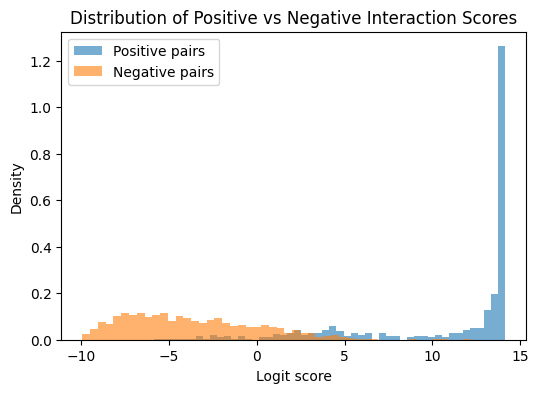

In [167]:
plt.figure(figsize=(6, 4))
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")
plt.legend()
plt.show()

#### non-dimers

In [93]:
Df_test_non_dimer = Df_test[Df_test.dimer == False]

non_dimers_Dataset = CLIP_PPint_analysis_dataset(
    Df_test_non_dimer,
    paths=[bemb_path, temb_path, bcont_path, tcont_path],
    embedding_dim=1280
)

non_dimers_dataloader = DataLoader(non_dimers_Dataset, batch_size=10, collate_fn=collate_varlen)

interaction_scores = []
for batch in tqdm(non_dimers_dataloader, total=round(len(Df_test_non_dimer)/10), desc="#Iterating through batched data"):
    b_emb, t_emb, b_cm, t_cm, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():
        positive_logits = model(embedding_pep, embedding_prot, b_cm, t_cm)
        interaction_scores.append(positive_logits.unsqueeze(0))

# Convert list of tensors to single 1D tensors
predicted_interaction_scores = np.concatenate([batch_score.cpu().detach().numpy().reshape(-1,) for batch_score in interaction_scores])

#Iterating through batched data: 100%|██████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.27it/s]


In [181]:
interaction_df_shuffled

,seq_binder,seq_target,target_id,binder_id,binder_label,seq_target_len,seq_binder_len,inter_prob,pred_binder,intr_scores
0,DIVEEAHKLLSRAMSEAMENDDPDKLRRANELYFKLEEALKNNDPK...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_124,True,101,62,0.048840,False,-2.969127
1,SEELVEKVVEEILNSDLSNDQKILETHDRLMELHDQGKISKEEYYK...,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,EGFR_2,EGFR_2_149,False,621,58,0.024884,False,-3.668321
2,TINRVFHLHIQGDTEEARKAHEELVEEVRRWAEELAKRLNLTVRVT...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_339,False,101,65,0.038206,False,-3.225821
3,DDLRKVERIASELAFFAAEQNDTKVAFTALELIHQLIRAIFHNDEE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1234,False,101,64,0.012214,False,-4.392912
4,DEEVEELEELLEKAEDPRERAKLLRELAKLIRRDPRLRELATEVVA...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_48,False,165,65,0.063571,False,-2.689916
...,...,...,...,...,...,...,...,...,...,...
3527,SEDELRELVKEIRKVAEKQGDKELRTLWIEAYDLLASLWYGAADEL...,TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFK...,SARS_CoV2_RBD,SARS_CoV2_RBD_25,False,195,63,0.004078,False,-5.498161
3528,TEEEILKMLVELTAHMAGVPDVKVEIHNGTLRVTVNGDTREARSVL...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2027,False,101,65,0.010529,False,-4.543035
3529,VEELKEARKLVEEVLRKKGDQIAEIWKDILEELEQRYQEGKLDPEE...,DYSFSCYSQLEVNGSQHSLTCAFEDPDVNTTNLEFEICGALVEVKC...,IL7Ra,IL7Ra_90,False,193,63,0.000456,False,-7.692770
3530,DAEEEIREIVEKLNDPLLREILRLLELAKEKGDPRLEAELYLAFEK...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1605,False,101,65,0.017046,False,-4.054659


#### meta-analysis

In [186]:
# Loading batches
interaction_scores = []

for batch in tqdm(validation_dataloader, total = round(len(interaction_df_shuffled)/10),  desc= "#Iterating through batched data"):
    b_emb, t_emb, b_cm, t_cm, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():
        positive_logits = model(embedding_pep, embedding_prot, b_cm, t_cm)
        interaction_scores.append(positive_logits.unsqueeze(0))

#Iterating through batched data: 354it [01:34,  3.74it/s]                                                                                           


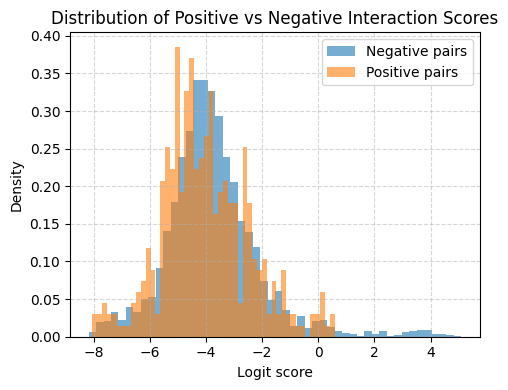

In [193]:
predicted_interaction_scores = np.concatenate([batch_score.cpu().detach().numpy().reshape(-1,) for batch_score in interaction_scores])
interaction_probabilities = np.concatenate([torch.sigmoid(batch_score[0]).cpu().numpy() for batch_score in interaction_scores])

pos_logits, neg_logits = [], []
for i, row in interaction_df_shuffled.iterrows():
    logit = predicted_interaction_scores[i]
    if row.binder_label == False:
        neg_logits.append(logit)
    elif row.binder_label == True:
        pos_logits.append(logit)

plt.figure(figsize=(5, 4))

plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)

plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")

# --- Simple grid behind ---
plt.grid(True, linestyle="--", alpha=0.5)

plt.legend()
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

       False     0.8880    0.9691    0.9268      3141
        True     0.0673    0.0179    0.0283       391

    accuracy                         0.8638      3532
   macro avg     0.4776    0.4935    0.4775      3532
weighted avg     0.7971    0.8638    0.8273      3532

AUC: 0.454


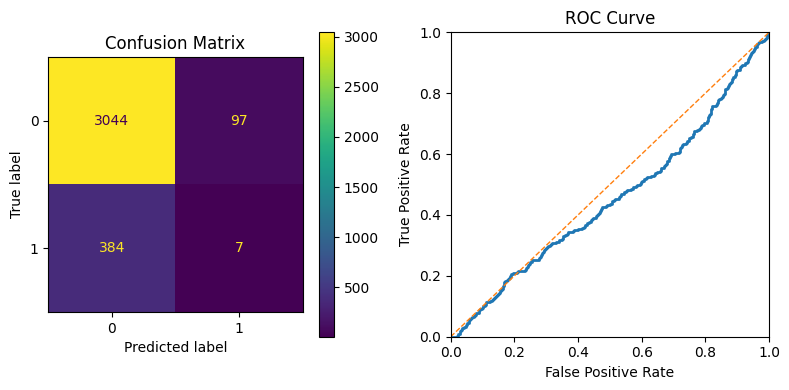

In [200]:
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

interaction_df_shuffled["inter_prob"] = interaction_probabilities
interaction_df_shuffled["pred_binder"] = interaction_df_shuffled["inter_prob"] >= 0.5
interaction_df_shuffled["intr_scores"] = predicted_interaction_scores

pred_labels = interaction_probabilities >= 0.5
true_labels = np.array(interaction_df_shuffled["binder_label"])

true_positives = ((pred_labels == 1) & (true_labels == 1)).sum().item()
true_negatives = ((pred_labels == 0) & (true_labels == 0)).sum().item()
false_positives = ((pred_labels == 1) & (true_labels == 0)).sum().item()
false_negatives = ((pred_labels == 0) & (true_labels == 1)).sum().item()

predicted_positives = true_positives + false_positives
all_real_positives = true_positives + false_negatives

print(sklearn.metrics.classification_report(true_labels, pred_labels, digits = 4))

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true_labels, pred_labels))
disp.plot(ax=axes[0])
axes[0].set_title("Confusion Matrix")

TPR = true_positives / (true_positives + true_negatives) # how good the model is at predicting the positive class when the actual outcome is positive.
# sensitivity = true_positives / (true_positives + false_negatives) # the same as TPR
FPR = false_positives / (false_positives + true_negatives) # how often a positive class is predicted when the actual outcome is negative.
# specificity = true_negatives / (true_negatives + false_positives) # FPR = 1 - specificity

fpr, tpr, thresholds = sklearn.metrics.roc_curve(true_labels, interaction_probabilities)
auc = roc_auc_score(true_labels, interaction_probabilities)
print('AUC: %.3f' % auc)

axes[1].plot(fpr, tpr, linewidth=2)
axes[1].plot([0, 1], [0, 1], linestyle="--", linewidth=1)  # diagonal reference
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].set_title('ROC Curve')

# show the plot
plt.tight_layout()
plt.show()